# Coursework 2
## MTH739P: Topics in Scientific Computing
### Gerardo Duran Martín

In [1]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings

In [3]:
default(size=(600, 300))
new = [CartesianIndex()];

## Question 1: pseudospectral methods

### a) Evaluation of a first derivative

Write a program that numerically evaluates the first derivative using pseudo-spectral methods of a function $f(x)$ evaluated a set of grid of points  $\left\{x_n = \frac{a + b}{2} + \frac{a - b}{2}\cos\theta_n\right\}_{n=0}^N$; where $a, b$ are the limits of the evaluation interval, $\theta_n = n\pi / N$. Evaluate the derivatives using the approximation

$$
    f'(x_n) = \sum_{m=0}^N D_{nm}f(x_m)
$$

Where $D_{nm}$ are the elements of the $(N+1)\times(N+1)$ Chebyshev derivative matrix given by

$$
    {\bf D}_{00} = -\frac{2N^2 + 1}{3(b-a)}
$$


$$
    {\bf D}_{nn} = \frac{\cos\theta_n}{(b-a) \sin^2\theta_n}
$$

$$
    {\bf D}_{NN} = \frac{2N^2+1}{3(b-a)}
$$


$$
    {\bf D}_{nm} = \frac{2 c_n (-1)^{n + m}}{(b-a) c_m (\cos \theta_m - \cos\theta_n)}
$$

With $c_n = 1 + \mathbb{1}(n=0) + \mathbb{1}(n=N)$

In [4]:
c(n, N) = 1 + (n == 0) + (n == N)


"""
Evaluate an entry of the chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

Parameters
----------
a: int
    Initial value
b: int
    Final value
n: int
    row of the matrix
m: int
    column of the matrix
N: int
    Lenght of matrix - 1


Returns
-------
array: (N+1) × (N+1) chebyshev matrix
"""
function D_entry_chebyshev(a, b, n, m, N)
    n, m = n - 1, m - 1
    θn = n * pi / N
    θm = m * pi / N
    
    if n == 0 && m == 0
        D = -(2N ^ 2 + 1) / 3(b - a)
    elseif n == N && m == N
        D = (2N ^ 2 + 1) / 3(b - a)
    elseif n == m
        D = cos(θn) / ((b - a) * sin(θn) ^ 2)
    else
        D = 2c(n, N) * (-1) ^ (n + m) / ((b - a) * c(m, N) * (cos(θm) - cos(θn)))
    end
    
    return D
end


"""
Create a Chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

Parameters
----------
a: int
    Lower bound of evaluation
b: int
    Upper bound of evaluation
N: int
    Number of gridpoints to evaluate
"""
function D_chebyshev(a, b, N)
    D = zeros(N + 1, N + 1)
    for n=1:N+1
        for m=1:N+1
            D[n, m] = D_entry_chebyshev(a, b, n, m, N)
        end
    end
    
    return D
end


"""
Create a grid point of N+1 values from
a to b to be used in the Chebyshev pseudospectral method

Parameters
----------
a: int
    Lower evaluation bound
b: int
    Upper evaluation bound
N: int
    Total number of points from a to b (plus 1)
"""
function range_chebyshev(a, b; lenght)
    θvals = (0:lenght) .* pi / lenght
    xvals = (a + b) / 2. .+ (a - b) / 2. .* cos.(θvals)
    
    return xvals
end


"""
Evaluate the derivative of a function f:R->R using a
pseudo-spectral method using a Chebyshev
"""
function DChebyshev(f, a, b, N)
    xrange = range_chebyshev(a, b, lenght=N)
    D = D_chebyshev(a, b, N)
    # For stability and accuracy purposes, we replace each element
    # of the main diagonal with the negative sum of all matrix elements
    # in the same row
    D[diagind(D)] = -sum(D .* (ones(N+1, N+1) - I), dims=2)
    df_values = D * f.(xrange)
    
    return xrange, df_values
end


DChebyshev

In [5]:
f(x) = exp(-x^2)
df(x) = -2x * exp(-x^2)

df (generic function with 1 method)

### b) Numerical error

In this section we approximate the derivative of a function $f$ and compare it against its analytical solution by plotting the difference
    
$$
    \frac{d}{dx}f_\texttt{numerical}(x) - \frac{d}{dx}f_\texttt{analytical}(x)
$$

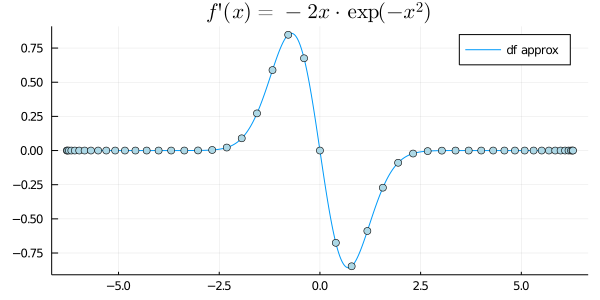

In [6]:
a, b = -2pi, 2pi
N = 5000
xrange, df_approx = DChebyshev(f, a, b, N)
plot(xrange, df_approx, label="df approx", title=L"f'(x) = -2x \cdot \exp(-x^2)")
plot!(xrange[begin:100:end], df_approx[begin:100:end], marker=true, linewidth=0, label=nothing, color="lightBlue")

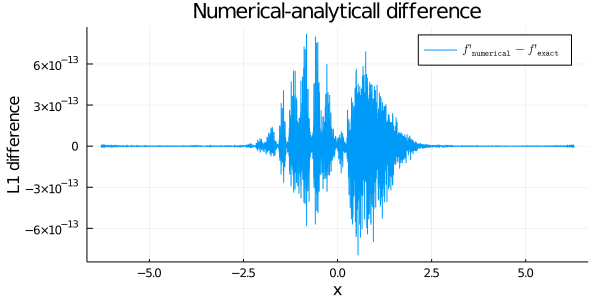

In [7]:
plot(xrange, df.(xrange) - df_approx, ylabel="L1 difference", xlabel="x",
     title="Numerical-analyticall difference", label=L"f'_\texttt{numerical} - f'_\texttt{exact}")

### c) L1 error norm

In this section we show that the difference between our numerical derivatives and the known analytical ones approaches zero. 

You might do this by graphing $\exp(N)\ell_1 \sim C$ or $\log\ell_1 \sim C - N$ for several values of $N$, where $\ell_1 = \sum_{n=0}^N |f'_\texttt{numerical}(x_n) - f'_\texttt{analytical}(x_n)|$

In [8]:
Nmax = 1000

Nrange = 10:20:Nmax
l1_values = zeros(length(Nrange))
for (i, N) in enumerate(Nrange)
    xrange, df_approx = DChebyshev(f, a, b, N)
    l1 = sum(abs.(df.(xrange) - df_approx))
    l1_values[i] = l1
end

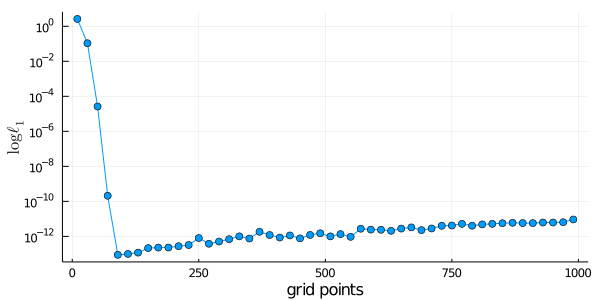

In [9]:
plot(Nrange, l1_values, label=nothing, marker=true, xlabel="grid points", ylabel=L"\log\ell_1", yaxis=:log)

## Question 2: ODE Integration

Consider the pendulum described by the first-order system

$$
\begin{align*}
\frac{dq}{dt} &= p\\
\frac{dp}{dt} &= f(q)\\
\end{align*}
$$

Where $f(q) = -V'(q) = -\sin(q)$; $V(q) = 1 - \cos(q)$

In [10]:
f(q) = -sin(q)
V(q) = 1 - cos(q)

V (generic function with 1 method)

### Using Runge-Kutta 2

In [11]:
"""
Implementation of a second-order Runge-Kutta ODE
solver

Parameters
----------
fs: Tuple
    Collection of m functions for the ode
    ẋ = f(x)
initial_conditions: Array
    Collection of m initial conditions
Δt: float
    Timestep size
T: float / int
    Time of integration

Returns
-------
Array of size (T / Δt + 1, m) of the integration
the system from 0 to T
"""
function rk2(fs, initial_conditions, Δt, T)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        k1 = Δt .* [f(yn...) for f in fs]
        k2 = Δt .* [f(yn + k1 / 2...) for f in fs]
        yn = yn + k2
        hist[ti, :] = yn
    end
    
    return hist
end

rk2

In [12]:
vmin, vmax = -2pi, 2pi

xs = vmin:pi/3:vmax
ys = vmin:pi/3:vmax

df(x, y) = [y, -sin(x)] ./ 3.5

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys];

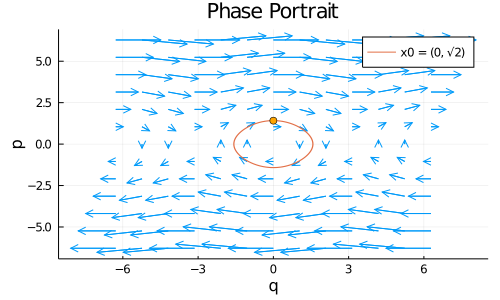

In [13]:
T = 100
dt = 0.1
system = ((q, p) -> p, (q, p) -> f(q))
cond0 = [0, sqrt(2)]

qp_hist = rk2(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

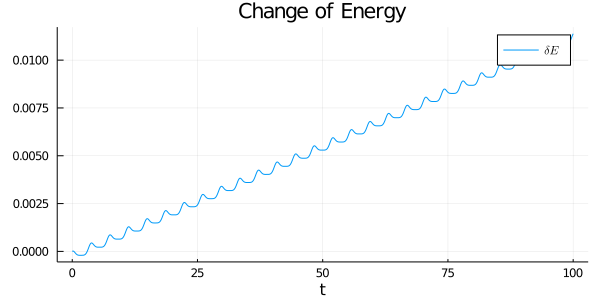

In [14]:
# Energy
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

### Using the Trapezium rule

$$
\begin{align*}
    q(t_{n+1}) - q(t_n) &\approx \frac{\Delta t}{2}[p(t_{n+1} + p_{t_n})]\\
    p(t_{n+1}) - p(t_n) &\approx \frac{\Delta t}{2}\left[f\big(q(t_{n+1})\big) + f\big(q(t_n)\big)\right]\\
\end{align*}
$$

In [50]:
function trapezoidal(fs, initial_conditions, Δt, T, inner_it=10)
    yn = initial_conditions[:]
    n_steps = Int(T / Δt + 1)
    n_params = length(initial_conditions)
    
    hist = zeros(n_steps, n_params)
    hist[1, :] = yn
    
    for ti=2:n_steps
        # RK2 as initial guess
        y_old = rk2(fs, yn, dt, dt)[end, :]
        for _ in 1:inner_it
            y_new = yn + Δt / 2 .* [f(y_old...) + f(yn...) for f in fs]
            y_old = y_new
        end
        yn = y_old
        hist[ti, :] = yn
    end
    
    return hist
end

trapezoidal (generic function with 2 methods)

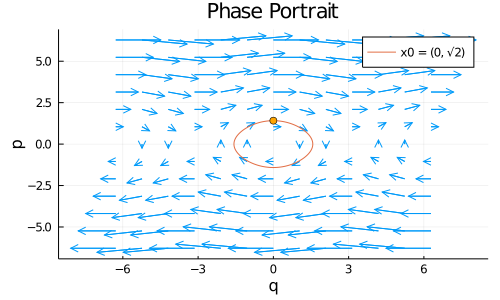

In [51]:
qp_hist = trapezoidal(system, cond0, dt, T)

quiver(xxs, yys, quiver=df, size=(500, 300), xlabel="q", ylabel="p")
plot!(qp_hist[:, 1], qp_hist[:, 2], title="Phase Portrait", label="x0 = (0, √2)")
scatter!(qp_hist[1, [1]], qp_hist[1, [2]], label=nothing, color="orange")

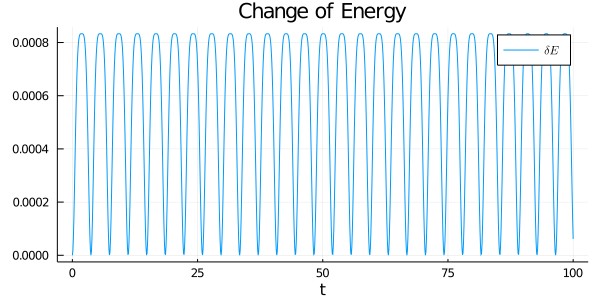

In [52]:
# Energy
E = qp_hist[:, 2] .^ 2 / 2 + V.(qp_hist[:, 1])
plot(0:dt:T, E .- E[begin], title="Change of Energy", label=L"\delta E", xlabel="t")

## Question 3: PDE Integration